In [3]:
import numpy as np
import scipy.io
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

def dataloader(path):
    data = scipy.io.loadmat(path)
    AF = data['AF']
    modified_rows1 = AF[:-2]
    last_rows1 = AF[-2:]
    CF = data['CF']
    concatenated_array = np.concatenate((modified_rows1, CF,last_rows1), axis=0)
    new=concatenated_array
    u, count = np.unique(new[-1], return_counts=True)
    a = u[np.logical_or(count < 2, count > 2)]
    c = new[:, np.isin(new[-1], a, invert=True)]
    x = c[0:-2]; y = c[-2]; w = c[-1];
    return x.T, y.T, w.T, data['CF_info']

def calculate_accuracy(arr1, arr2):
    count = sum(1 for itr1, itr2 in zip(arr1, arr2) if itr1 == itr2)
    return count / len(arr1)

def count_zeros(array):
    count = 0
    for element in array:
        if element == 0:
            count += 1
    return count

def normalization(feats):
    df = pd.DataFrame(feats)
    scaler = StandardScaler()
    x_new = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return x_new
    
def calculate_confidence(soft_assignments):
    # Calculate confidence as the maximum soft assignment value
    confidence = np.max(soft_assignments, axis=1)
    return confidence
        
fatyp = 'TypicalFA_comb1'
drivepath = 'finalData/'+ fatyp +'/';
filee = drivepath+'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress.mat'
original_dim = 38
train_path = filee; test_path = filee.replace('train','test')
xtrain, ytrain, wtrain1, info_train1 = dataloader(train_path);
xtest, ytest, wtest1, info_test1 = dataloader(test_path);
xtest= normalization(xtest)
xtrain= normalization(xtrain)

woPP=[]; wPP=[]
input_shape1 = (19,1)
input_shape2 = (38,1)
temperature = 0.03
learning_rate=0.001

2023-07-11 05:56:59.812338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


16/16 [==============================] - 1s 4ms/step - loss: 1.1712 - dense_27_loss: -3.0814e-06 - dense_26_loss: 1.1712
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.9589 - dense_27_loss: -3.0627e-06 - dense_26_loss: 0.9589
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.9006 - dense_27_loss: -3.0261e-06 - dense_26_loss: 0.9006
Epoch 4/50
16/16 [==============================] - 0s 4ms/step - loss: 0.8691 - dense_27_loss: -3.0147e-06 - dense_26_loss: 0.8691
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.8330 - dense_27_loss: -3.0187e-06 - dense_26_loss: 0.8330
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7899 - dense_27_loss: -2.9873e-06 - dense_26_loss: 0.7899
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7469 - dense_27_loss: -2.9434e-06 - dense_26_loss: 0.7469
Epoch 8/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7130 - dense_

/tmp/ipykernel_256/3522537989.py:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(encoded_data_2d[:, 0], encoded_data_2d[:, 1], cmap='viridis')


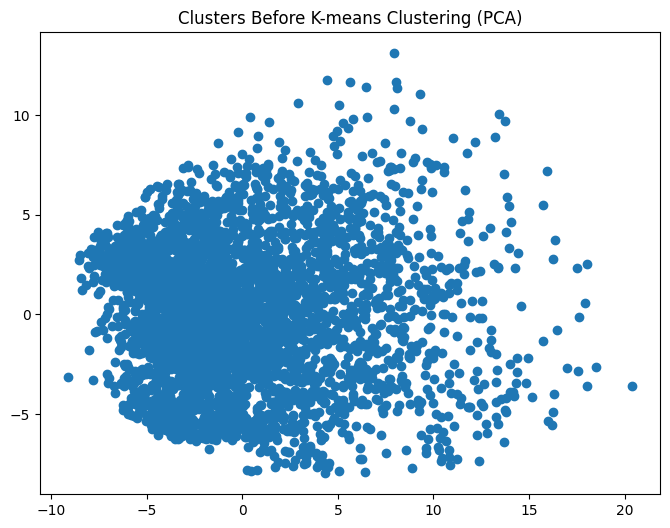

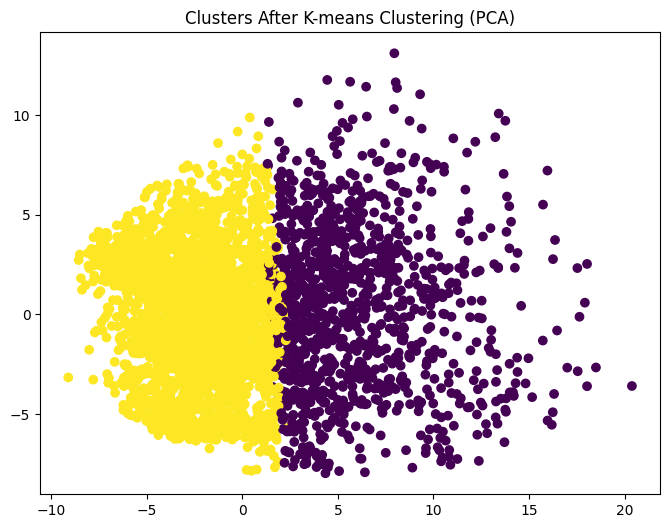

In [7]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

n_clusters = 2
input_shape = xtrain.shape[1]

input_data = Input(shape=(input_shape,))
encoded = Dense(128, activation='relu')(input_data)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)  # 32-dimensional latent space

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_shape, activation='sigmoid')(decoded)

autoencoder = Model(input_data, decoded)

# Clustering layer
clustering_layer = Dense(n_clusters, activation='softmax')(encoded)

# IDEC model
model = Model(inputs=input_data, outputs=[clustering_layer, autoencoder.output])

# Set hyperparameters
batch_size = 256
epochs = 50
lr = 0.001

# Compile the model
model.compile(optimizer=Adam(lr=lr), loss=['kld', 'mse'], loss_weights=[0.1, 1])

# Pretrain the autoencoder
model.fit(xtrain, [np.zeros((len(xtrain), n_clusters)), xtrain], batch_size=batch_size, epochs=epochs)

# Extract the learned features
encoder = Model(inputs=model.input, outputs=model.layers[2].output)
encoded_data = encoder.predict(xtrain)

# Apply PCA for dimensionality reduction and visualization
pca = PCA(n_components=2)
encoded_data_2d = pca.fit_transform(encoded_data)

# Visualize clusters before K-means clustering
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data_2d[:, 0], encoded_data_2d[:, 1], cmap='viridis')
plt.title('Clusters Before K-means Clustering (PCA)')
plt.show()

# Apply K-means clustering on the learned features
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoded_data)

# Visualize clusters after K-means clustering
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data_2d[:, 0], encoded_data_2d[:, 1], c=y_pred, cmap='viridis')
plt.title('Clusters After K-means Clustering (PCA)')
plt.show()


Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


16/16 [==============================] - 1s 5ms/step - loss: 1.0548 - dense_63_loss: -2.0907e-06 - dense_62_loss: 1.0548
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 1.0000 - dense_63_loss: -1.6118e-06 - dense_62_loss: 1.0000
Epoch 3/50
16/16 [==============================] - 0s 5ms/step - loss: 1.0000 - dense_63_loss: -1.6118e-06 - dense_62_loss: 1.0000
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 1.0000 - dense_63_loss: -1.6118e-06 - dense_62_loss: 1.0000
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 1.0000 - dense_63_loss: -1.6118e-06 - dense_62_loss: 1.0000
Epoch 6/50
16/16 [==============================] - 0s 5ms/step - loss: 1.0000 - dense_63_loss: -1.6118e-06 - dense_62_loss: 1.0000
Epoch 7/50
16/16 [==============================] - 0s 5ms/step - loss: 1.0000 - dense_63_loss: -1.6118e-06 - dense_62_loss: 1.0000
Epoch 8/50
16/16 [==============================] - 0s 5ms/step - loss: 1.0000 - dense_

/tmp/ipykernel_256/2018614657.py:54: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(encoded_data_2d[:, 0], encoded_data_2d[:, 1], cmap='viridis')


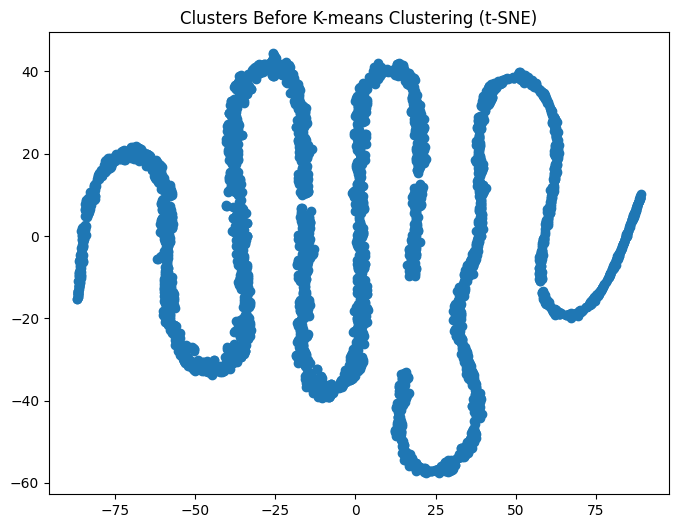

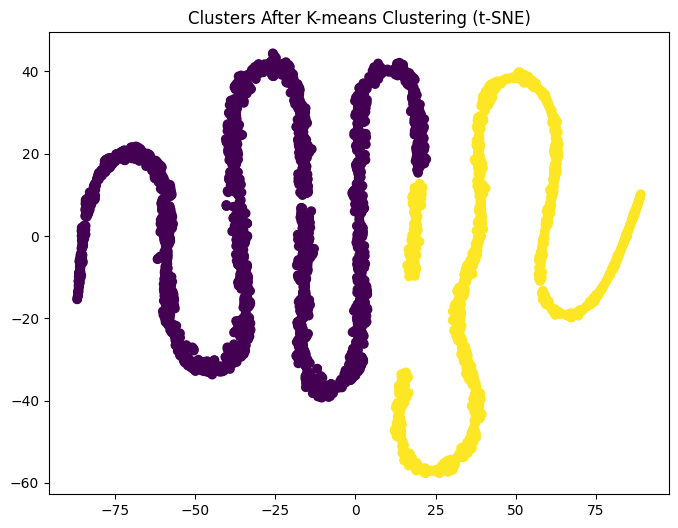

In [17]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.manifold import TSNE
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

n_clusters = 2

input_data = Input(shape=(input_shape,))
encoded = Dense(500, activation='relu')(input_data)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='relu')(encoded)  # 10-dimensional latent space

# Decoder
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(input_shape, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(input_data, decoded)

# Clustering layer
clustering_layer = Dense(n_clusters, activation='softmax')(encoded)

# IDEC model
model = Model(inputs=input_data, outputs=[clustering_layer, autoencoder.output])

# Set hyperparameters
batch_size = 256
epochs = 50
lr = 0.001

# Compile the model
model.compile(optimizer=Adam(lr=lr), loss=['kld', 'mse'], loss_weights=[0.1, 1])

# Pretrain the autoencoder
model.fit(xtrain, [np.zeros((len(xtrain), n_clusters)), xtrain], batch_size=batch_size, epochs=epochs)

# Extract the learned features
encoder = Model(inputs=model.input, outputs=model.layers[4].output)
encoded_data = encoder.predict(xtrain)

# Apply t-SNE for dimensionality reduction and visualization
tsne = TSNE(n_components=2, random_state=42)
encoded_data_2d = tsne.fit_transform(encoded_data)

# Visualize clusters before K-means clustering
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data_2d[:, 0], encoded_data_2d[:, 1], cmap='viridis')
plt.title('Clusters Before K-means Clustering (t-SNE)')
plt.show()

# Apply K-means clustering on the learned features
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoded_data)

# Visualize clusters after K-means clustering
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data_2d[:, 0], encoded_data_2d[:, 1], c=y_pred, cmap='viridis')
plt.title('Clusters After K-means Clustering (t-SNE)')
plt.show()


In [15]:
from sklearn.metrics import accuracy_score

def check_similarity(y_true, y_pred):
    similarity = accuracy_score(y_true, y_pred)
    return similarity

In [16]:
print(check_similarity(ytrain,y_pred))

0.6251261352169526
